In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 133.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 114.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 115.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [1]:
# Download sample data
!gdown 1Ie1g9ajkay5m8P7rMaO_i2Zr9YFc3wEd -O Dataset_sample.zip
!unzip Dataset_sample.zip

Downloading...
From (original): https://drive.google.com/uc?id=1Ie1g9ajkay5m8P7rMaO_i2Zr9YFc3wEd
From (redirected): https://drive.google.com/uc?id=1Ie1g9ajkay5m8P7rMaO_i2Zr9YFc3wEd&confirm=t&uuid=59dd0f80-8ceb-4ea3-bdc9-9566e6821434
To: /content/Dataset_sample.zip
100% 403M/403M [00:06<00:00, 60.3MB/s]
Archive:  Dataset_sample.zip
  inflating: Dataset_sample/desktop.ini  
   creating: Dataset_sample/labeling/
  inflating: Dataset_sample/labeling/desktop.ini  
   creating: Dataset_sample/labeling/N/
  inflating: Dataset_sample/labeling/N/desktop.ini  
   creating: Dataset_sample/labeling/N/training/
   creating: Dataset_sample/labeling/N/training/00047_H_A_N_C1/
  inflating: Dataset_sample/labeling/N/training/00047_H_A_N_C1/00047_H_A_N_C1.json  
  inflating: Dataset_sample/labeling/N/training/00047_H_A_N_C1/desktop.ini  
   creating: Dataset_sample/labeling/N/training/00047_H_A_N_C2/
  inflating: Dataset_sample/labeling/N/training/00047_H_A_N_C2/00047_H_A_N_C2.json  
  inflating: Datase

In [4]:
from ultralytics import YOLO
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm
import json
import torch

def letterbox(img, target_size=(320, 320), color=(114, 114, 114)):
    h, w = img.shape[:2]
    target_w, target_h = target_size
    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    dw = target_w - new_w
    dh = target_h - new_h
    top, bottom = dh // 2, dh - (dh // 2)
    left, right = dw // 2, dw - (dw // 2)

    padded = cv2.copyMakeBorder(resized, top, bottom, left, right,
                                cv2.BORDER_CONSTANT, value=color)
    return padded

# 모델 로드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YOLO("yolo11n-pose.pt")
model.model.to(device)

# 경로 설정
video_root = Path("/content/Dataset_sample/source")
labeling_root = Path("/content/Dataset_sample/labeling")
output_root = Path(f"/content/pose_tensor_npz")

# ✅ 타겟 FPS 설정
target_fps = 5
target_frame_count = 50  # 총 추출할 프레임 수

# 영상 파일 순회
for video_path in tqdm(video_root.rglob("*.mp4")):
    cap = cv2.VideoCapture(str(video_path))
    poses, confs, labels = [], [], []

    video_fps = cap.get(cv2.CAP_PROP_FPS)
    if video_fps == 0:
        print(f"[❌FPS 오류] {video_path.name} 영상의 FPS를 가져올 수 없음")
        cap.release()
        continue
    interval_frame = int(round(video_fps / target_fps))
    print(f"[🎯 {video_path.name}] 영상 FPS: {video_fps:.2f}, 추출 간격: {interval_frame}프레임마다")

    # JSON 파일(label) 로드
    json_path = labeling_root / video_path.relative_to(video_root).with_suffix(".json")
    if not json_path.exists():
        print(f"[❗JSON 없음] {json_path}")
        cap.release()
        continue

    with open(json_path, "r", encoding="utf-8") as f:
        json_data = json.load(f)
        fall_start = json_data["sensordata"].get("fall_start_frame", 0)
        fall_end = json_data["sensordata"].get("fall_end_frame", 0)

    for i in range(target_frame_count):
        frame_idx = i * interval_frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()

        if not ret:
            pose = np.zeros((17, 2))
            conf = np.zeros(17)
            poses.append(pose)
            confs.append(conf)
            labels.append(0)
            continue

        # 먼저 320x240으로 frame을 resize한 뒤 320x320으로 letterbox 처리
        try:
            resized = cv2.resize(frame, (320, 240))
            frame_input = letterbox(resized, target_size=(320, 320))
        except Exception as e:
            print(f"[❌리사이즈 실패] {video_path.name} 프레임 {frame_idx}: {e}")
            pose = np.zeros((17, 2))
            conf = np.zeros(17)
            poses.append(pose)
            confs.append(conf)
            labels.append(0)
            continue

        try:
            results = model.predict(source=frame_input, imgsz=320, save=False, verbose=False)
            keypoints = results[0].keypoints

            # keypoints 미검출 및 shape 오류 확인
            if (
                keypoints is None or
                not hasattr(keypoints, "xyn") or
                not hasattr(keypoints, "data") or
                keypoints.xyn is None or
                keypoints.data is None or
                len(keypoints.xyn) == 0 or
                keypoints.data.shape[1:] != (17, 3)
            ):
                raise ValueError("Keypoints 미검출 또는 shape 오류")

            # 첫 번째 사람 기준으로 keypoint 추출
            raw_pose = keypoints.xyn[0].cpu().numpy()
            raw_conf = keypoints.data[0][:, 2].cpu().numpy()

            if raw_pose.shape != (17, 2) or raw_conf.shape != (17,):
                raise ValueError(f"추출된 shape 이상함: pose={raw_pose.shape}, conf={raw_conf.shape}")

            pose = raw_pose.copy()
            conf = raw_conf.copy()

            # confidence threshold를 기준으로 threshold 미만의 keypoint는 0으로 마스킹 처리
            threshold = 0.2
            low_conf_mask = conf < threshold
            pose[low_conf_mask] = 0
            if np.any(low_conf_mask):
                print(f"[⚠️ {np.sum(low_conf_mask)}개 마스킹됨] {video_path.name} 프레임 {frame_idx}")
            else:
                print(f"✅ 모든 skeleton points 저장 완료")

        except Exception as e:
            print(f"[❌Keypoint 오류] {video_path.name} 프레임 {frame_idx}: {e}")
            pose = np.zeros((17, 2))
            conf = np.zeros(17)

        poses.append(pose)
        confs.append(conf)
        labels.append(1 if fall_start <= frame_idx <= fall_end else 0)

    cap.release()

    try:
        poses_np = np.stack(poses, axis=0)
        confs_np = np.stack(confs, axis=0)
        labels_np = np.array(labels)
    except ValueError as e:
        print(f"[❌스택 오류] {video_path.name}: {e}")
        continue

    # 처리 완료된 npz 파일 저장
    relative_path = video_path.relative_to(video_root).with_suffix("")
    save_dir = output_root / relative_path.parent
    save_dir.mkdir(parents=True, exist_ok=True)
    save_path = save_dir / f"{relative_path.name}.npz"

    np.savez(save_path, pose=poses_np, confidence=confs_np, label=labels_np)
    print(f"[💾저장 완료] {save_path}")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.97M/5.97M [00:00<00:00, 56.8MB/s]
0it [00:00, ?it/s]

[🎯 00003_H_A_FY_C2.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
[⚠️ 3개 마스킹됨] 00003_H_A_FY_C2.mp4 프레임 0
[⚠️ 2개 마스킹됨] 00003_H_A_FY_C2.mp4 프레임 12
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C2.mp4 프레임 24
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C2.mp4 프레임 36
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C2.mp4 프레임 48
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C2.mp4 프레임 60
[⚠️ 2개 마스킹됨] 00003_H_A_FY_C2.mp4 프레임 72
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C2.mp4 프레임 84
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C2.mp4 프레임 96
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C2.mp4 프레임 108
[⚠️ 2개 마스킹됨] 00003_H_A_FY_C2.mp4 프레임 120
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C2.mp4 프레임 132
[⚠️ 2개 마스킹됨] 00003_H_A_FY_C2.mp4 프레임 144
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C2.mp4 프레임 156
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C2.mp4 프레임 168
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C2.mp4 프레임 180
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C2.mp4 프레임 192
[⚠️ 2개 마스킹됨] 00003_H_A_FY_C2.mp4 프레임 204
[⚠️ 2개 마스킹됨] 00003_H_A_FY_C2.mp4 프레임 216
[⚠️ 2개 마스킹됨] 00003_H_A_FY_C2.mp4 프레임 228
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C2.mp4 프레임 240
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C2.mp4 프레임 252
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C2.mp4 프레임 264
[⚠️ 3개 마스킹됨] 

1it [00:23, 23.18s/it]

[⚠️ 2개 마스킹됨] 00003_H_A_FY_C2.mp4 프레임 588
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/Y/training/00003_H_A_FY_C2/00003_H_A_FY_C2.npz
[🎯 00003_H_A_FY_C7.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C7.mp4 프레임 288
✅ 모든 skeleton points 저장 완료
[⚠️ 3개 마스킹됨] 00003_H_A_FY_C7.mp4 프레임 312
[❌Keypoint 오류] 00003_H_A_FY_C7.mp4 프레임 324: Keypoints

2it [00:40, 19.60s/it]

✅ 모든 skeleton points 저장 완료
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/Y/training/00003_H_A_FY_C7/00003_H_A_FY_C7.npz
[🎯 00015_H_A_SY_C5.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
[⚠️ 2개 마스킹됨] 00015_H_A_SY_C5.mp4 프레임 0
[⚠️ 2개 마스킹됨] 00015_H_A_SY_C5.mp4 프레임 12
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C5.mp4 프레임 24
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C5.mp4 프레임 36
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C5.mp4 프레임 132
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C5.mp4 프레임 144
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C5.mp4 프레임 156
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C5.mp4 프레임 168
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C5.mp4 프레임 180
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C5.mp4 프레임 192
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C5.mp4 프레임 204
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C5.mp4 프레임 228
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C5.mp4 프레임 240
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C5.mp4 프레임 252
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨]

3it [00:56, 17.95s/it]

✅ 모든 skeleton points 저장 완료
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/Y/training/00015_H_A_SY_C5/00015_H_A_SY_C5.npz
[🎯 00003_H_A_FY_C8.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C8.mp4 프레임 228
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C8.mp4 프레임 240
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C8.mp4 프레임 264
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C8.mp4 프레임 276
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C8.mp4 프레임 288
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C8.mp4 프레임 300
[⚠️ 3개 마스킹됨] 00003_H_A_FY_C8.mp4 프레임 3

4it [01:12, 17.44s/it]

✅ 모든 skeleton points 저장 완료
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/Y/training/00003_H_A_FY_C8/00003_H_A_FY_C8.npz
[🎯 00015_H_A_SY_C2.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C2.mp4 프레임 12
[⚠️ 2개 마스킹됨] 00015_H_A_SY_C2.mp4 프레임 24
[⚠️ 6개 마스킹됨] 00015_H_A_SY_C2.mp4 프레임 36
[⚠️ 6개 마스킹됨] 00015_H_A_SY_C2.mp4 프레임 48
[⚠️ 5개 마스킹됨] 00015_H_A_SY_C2.mp4 프레임 60
[⚠️ 3개 마스킹됨] 00015_H_A_SY_C2.mp4 프레임 72
[⚠️ 4개 마스킹됨] 00015_H_A_SY_C2.mp4 프레임 84
[⚠️ 3개 마스킹됨] 00015_H_A_SY_C2.mp4 프레임 96
[⚠️ 2개 마스킹됨] 00015_H_A_SY_C2.mp4 프레임 108
[⚠️ 2개 마스킹됨] 00015_H_A_SY_C2.mp4 프레임 120
[⚠️ 2개 마스킹됨] 00015_H_A_SY_C2.mp4 프레임 132
[⚠️ 4개 마스킹됨] 00015_H_A_SY_C2.mp4 프레임 144
[⚠️ 4개 마스킹됨] 00015_H_A_SY_C2.mp4 프레임 156
[⚠️ 5개 마스킹됨] 00015_H_A_SY_C2.mp4 프레임 168
[⚠️ 3개 마스킹됨] 00015_H_A_SY_C2.mp4 프레임 180
[⚠️ 2개 마스킹됨] 00015_H_A_SY_C2.mp4 프레임 192
[⚠️ 2개 마스킹됨] 00015_H_A_SY_C2.mp4 프레임 204
[⚠️ 2개 마스킹됨] 00015_H_A_SY_C2.mp4 프레임 216
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C2.mp4 프레임 228
[⚠️ 2개 마스킹됨] 00015_H_A_SY_

5it [01:29, 17.10s/it]

[⚠️ 2개 마스킹됨] 00015_H_A_SY_C2.mp4 프레임 588
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/Y/training/00015_H_A_SY_C2/00015_H_A_SY_C2.npz
[🎯 00003_H_A_FY_C5.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C5.mp4 프레임 0
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C5.mp4 프레임 12
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C5.mp4 프레임 24
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C5.mp4 프레임 36
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C5.mp4 프레임 48
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C5.mp4 프레임 60
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C5.mp4 프레임 72
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C5.mp4 프레임 84
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C5.mp4 프레임 96
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C5.mp4 프레임 108
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C5.mp4 프레임 120
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C5.mp4 프레임 132
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C5.mp4 프레임 144
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C5.mp4 프레임 156
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C5.mp4 프레임 168
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C5.mp4 프레임 180
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C5.mp4 프레임 192
[⚠️ 2개 마스킹됨] 00003_H_A_FY_C5.mp4 프레임 204
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C5.mp4 프레임 216
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C5.mp4 프레임 228


6it [01:45, 16.69s/it]

[⚠️ 1개 마스킹됨] 00003_H_A_FY_C5.mp4 프레임 588
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/Y/training/00003_H_A_FY_C5/00003_H_A_FY_C5.npz
[🎯 00003_H_A_FY_C6.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C6.mp4 프레임 300
[⚠️ 3개 마스킹됨] 00003_H_A_FY_C6.mp4 프레임 312
[⚠️ 3개 마스킹됨] 00003_H_A_FY_C6.mp4 프레임 324
✅ 모든 skeleto

7it [02:01, 16.66s/it]

✅ 모든 skeleton points 저장 완료
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/Y/training/00003_H_A_FY_C6/00003_H_A_FY_C6.npz
[🎯 00015_H_A_SY_C3.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C3.mp4 프레임 48
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C3.mp4 프레임 60
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C3.mp4 프레임 72
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C3.mp4 프레임 108
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C3.mp4 프레임 180
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C3.mp4 프레임 192
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C3.mp4 프레임 204
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C3.mp4 프레임 216
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C3.mp4 프레임 228
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C3.mp4 프레임 240
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C3.mp4 프레임 252
✅ 모든 skeleton points 저장 완료
[⚠️ 2개 마스킹됨] 00015_H_A_SY_C3.mp4 프레임 276
[⚠️ 2개 마스킹됨

8it [02:18, 16.55s/it]

[⚠️ 3개 마스킹됨] 00015_H_A_SY_C3.mp4 프레임 588
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/Y/training/00015_H_A_SY_C3/00015_H_A_SY_C3.npz
[🎯 00015_H_A_SY_C4.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[⚠️ 2개 마스킹됨] 00015_H_A_SY_C4.mp4 프레임 288
✅ 모든 skeleton points 저장 완료
[⚠️ 2개 마스킹됨] 00015_H_A_SY_C4.mp4 프레임 312
✅ 모든 skeleton points 저장 완료
[⚠️ 2개 마스킹됨] 00015_H_A_SY_

9it [02:34, 16.43s/it]

[⚠️ 1개 마스킹됨] 00015_H_A_SY_C4.mp4 프레임 588
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/Y/training/00015_H_A_SY_C4/00015_H_A_SY_C4.npz
[🎯 00003_H_A_FY_C3.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[⚠️ 2개 마스킹됨] 00003_H_A_FY_C3.mp4 프레임 228
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C3.mp4 프레임 264
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C3.mp4 프레임 276
[⚠️ 2개 마스킹됨] 00003_H_A_FY_C3.mp4 프레임 288
[⚠️ 2개 마스킹됨] 00003_H_A_FY_C3.mp4 프레임 300
✅ 모든 skeleton points 저장 완료
[❌Keypoint 

10it [02:51, 16.50s/it]

✅ 모든 skeleton points 저장 완료
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/Y/training/00003_H_A_FY_C3/00003_H_A_FY_C3.npz
[🎯 00015_H_A_SY_C6.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C6.mp4 프레임 0
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C6.mp4 프레임 12
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C6.mp4 프레임 288
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 

11it [03:06, 16.33s/it]

[⚠️ 1개 마스킹됨] 00015_H_A_SY_C6.mp4 프레임 588
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/Y/training/00015_H_A_SY_C6/00015_H_A_SY_C6.npz
[🎯 00015_H_A_SY_C8.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C8.mp4 프레임 48
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C8.mp4 프레임 84
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C8.mp4 프레임 108
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C8.mp4 프레임 144
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C8.mp4 프레임 168
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C8.mp4 프레임 192
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C8.mp4 프레임 204
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C8.mp4 프레임 216
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C8.mp4 프레임 228
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C8.mp4 프레임 240
✅ 모든 skeleton points 저장 완료
[⚠️ 2개 마스킹됨] 00015_H_A_SY_C8.mp4 프레임 264
[⚠️ 2개 마스킹됨] 00015_H_A_SY_C8.mp4 프레임 

12it [03:23, 16.31s/it]

[⚠️ 3개 마스킹됨] 00015_H_A_SY_C8.mp4 프레임 588
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/Y/training/00015_H_A_SY_C8/00015_H_A_SY_C8.npz
[🎯 00003_H_A_FY_C4.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
[❌Keypoint 오류] 00003_H_A_FY_C4.mp4 프레임 0: Keypoints 미검출 또는 shape 오류
[❌Keypoint 오류] 00003_H_A_FY_C4.mp4 프레임 12: Keypoints 미검출 또는 shape 오류
[❌Keypoint 오류] 00003_H_A_FY_C4.mp4 프레임 24: Keypoints 미검출 또는 shape 오류
[❌Keypoint 오류] 00003_H_A_FY_C4.mp4 프레임 36: Keypoints 미검출 또는 shape 오류
[❌Keypoint 오류] 00003_H_A_FY_C4.mp4 프레임 48: Keypoints 미검출 또는 shape 오류
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[⚠️ 2개 마스킹됨] 00003_H_A_FY_C4.mp4 프레임 120
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C4.mp4 프레임 240
✅ 모든 s

13it [03:39, 16.31s/it]

[⚠️ 1개 마스킹됨] 00003_H_A_FY_C4.mp4 프레임 588
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/Y/training/00003_H_A_FY_C4/00003_H_A_FY_C4.npz
[🎯 00003_H_A_FY_C1.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
[⚠️ 5개 마스킹됨] 00003_H_A_FY_C1.mp4 프레임 0
[⚠️ 5개 마스킹됨] 00003_H_A_FY_C1.mp4 프레임 12
[⚠️ 5개 마스킹됨] 00003_H_A_FY_C1.mp4 프레임 24
[⚠️ 4개 마스킹됨] 00003_H_A_FY_C1.mp4 프레임 36
[⚠️ 5개 마스킹됨] 00003_H_A_FY_C1.mp4 프레임 48
[⚠️ 5개 마스킹됨] 00003_H_A_FY_C1.mp4 프레임 60
[⚠️ 4개 마스킹됨] 00003_H_A_FY_C1.mp4 프레임 72
[⚠️ 6개 마스킹됨] 00003_H_A_FY_C1.mp4 프레임 84
[⚠️ 3개 마스킹됨] 00003_H_A_FY_C1.mp4 프레임 96
[⚠️ 6개 마스킹됨] 00003_H_A_FY_C1.mp4 프레임 108
[⚠️ 2개 마스킹됨] 00003_H_A_FY_C1.mp4 프레임 120
[⚠️ 5개 마스킹됨] 00003_H_A_FY_C1.mp4 프레임 132
[⚠️ 3개 마스킹됨] 00003_H_A_FY_C1.mp4 프레임 144
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C1.mp4 프레임 156
[⚠️ 3개 마스킹됨] 00003_H_A_FY_C1.mp4 프레임 168
[⚠️ 3개 마스킹됨] 00003_H_A_FY_C1.mp4 프레임 180
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C1.mp4 프레임 192
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C1.mp4 프레임 204
[⚠️ 3개 마스킹됨] 00003_H_A_FY_C1.mp4 프레임 216
[⚠️ 1개 마스킹됨] 00003_H_A_FY_C1.mp4 프레임 228


14it [03:55, 16.22s/it]

✅ 모든 skeleton points 저장 완료
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/Y/training/00003_H_A_FY_C1/00003_H_A_FY_C1.npz
[🎯 00015_H_A_SY_C1.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
[⚠️ 3개 마스킹됨] 00015_H_A_SY_C1.mp4 프레임 0
[⚠️ 3개 마스킹됨] 00015_H_A_SY_C1.mp4 프레임 12
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C1.mp4 프레임 24
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C1.mp4 프레임 36
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C1.mp4 프레임 48
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C1.mp4 프레임 60
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C1.mp4 프레임 72
[⚠️ 2개 마스킹됨] 00015_H_A_SY_C1.mp4 프레임 84
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C1.mp4 프레임 96
[⚠️ 2개 마스킹됨] 00015_H_A_SY_C1.mp4 프레임 108
[⚠️ 2개 마스킹됨] 00015_H_A_SY_C1.mp4 프레임 120
[⚠️ 2개 마스킹됨] 00015_H_A_SY_C1.mp4 프레임 132
[⚠️ 3개 마스킹됨] 00015_H_A_SY_C1.mp4 프레임 144
[⚠️ 2개 마스킹됨] 00015_H_A_SY_C1.mp4 프레임 156
[⚠️ 3개 마스킹됨] 00015_H_A_SY_C1.mp4 프레임 168
[⚠️ 2개 마스킹됨] 00015_H_A_SY_C1.mp4 프레임 180
[⚠️ 2개 마스킹됨] 00015_H_A_SY_C1.mp4 프레임 192
[⚠️ 2개 마스킹됨] 00015_H_A_SY_C1.mp4 프레임 204
[⚠️ 2개 마스킹됨] 00015_H_A_SY_C1.mp4 프레임 216
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C1.mp4 프레임 228
[⚠️ 1개 마스킹됨] 0

15it [04:11, 16.05s/it]

[⚠️ 1개 마스킹됨] 00015_H_A_SY_C1.mp4 프레임 588
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/Y/training/00015_H_A_SY_C1/00015_H_A_SY_C1.npz
[🎯 00015_H_A_SY_C7.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C7.mp4 프레임 276
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C7.mp4 프레임 288
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00015_H_A_SY_C7.mp4 프레임 312
✅ 모든 skeleton points 저장 완료
[⚠️ 2개 마스킹됨]

16it [04:27, 16.06s/it]

[⚠️ 1개 마스킹됨] 00015_H_A_SY_C7.mp4 프레임 588
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/Y/training/00015_H_A_SY_C7/00015_H_A_SY_C7.npz
[🎯 00151_H_A_BY_C1.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
[⚠️ 3개 마스킹됨] 00151_H_A_BY_C1.mp4 프레임 0
[⚠️ 3개 마스킹됨] 00151_H_A_BY_C1.mp4 프레임 12
[⚠️ 1개 마스킹됨] 00151_H_A_BY_C1.mp4 프레임 24
[❌Keypoint 오류] 00151_H_A_BY_C1.mp4 프레임 36: Keypoints 미검출 또는 shape 오류
[❌Keypoint 오류] 00151_H_A_BY_C1.mp4 프레임 48: Keypoints 미검출 또는 shape 오류
[⚠️ 1개 마스킹됨] 00151_H_A_BY_C1.mp4 프레임 60
[❌Keypoint 오류] 00151_H_A_BY_C1.mp4 프레임 72: Keypoints 미검출 또는 shape 오류
[⚠️ 1개 마스킹됨] 00151_H_A_BY_C1.mp4 프레임 84
[⚠️ 1개 마스킹됨] 00151_H_A_BY_C1.mp4 프레임 96
[⚠️ 1개 마스킹됨] 00151_H_A_BY_C1.mp4 프레임 108
[⚠️ 1개 마스킹됨] 00151_H_A_BY_C1.mp4 프레임 120
[⚠️ 1개 마스킹됨] 00151_H_A_BY_C1.mp4 프레임 132
[⚠️ 1개 마스킹됨] 00151_H_A_BY_C1.mp4 프레임 144
[⚠️ 1개 마스킹됨] 00151_H_A_BY_C1.mp4 프레임 156
[⚠️ 1개 마스킹됨] 00151_H_A_BY_C1.mp4 프레임 168
[⚠️ 1개 마스킹됨] 00151_H_A_BY_C1.mp4 프레임 180
✅ 모든 skeleton points 저장 완료
[❌Keypoint 오류] 00151_H_A_BY_C1.mp4 프레임 204: Keypoi

17it [04:35, 13.73s/it]

✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/Y/validation/00151_H_A_BY_C1/00151_H_A_BY_C1.npz
[🎯 00151_H_A_BY_C6.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleto

18it [04:43, 12.03s/it]

[⚠️ 1개 마스킹됨] 00151_H_A_BY_C6.mp4 프레임 588
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/Y/validation/00151_H_A_BY_C6/00151_H_A_BY_C6.npz
[🎯 00151_H_A_BY_C3.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00151_H_A_BY_C3.mp4 프레임 48
[⚠️ 2개 마스킹됨] 00151_H_A_BY_C3.mp4 프레임 60
[⚠️ 1개 마스킹됨] 00151_H_A_BY_C3.mp4 프레임 72
[⚠️ 1개 마스킹됨] 00151_H_A_BY_C3.mp4 프레임 84
[⚠️ 1개 마스킹됨] 00151_H_A_BY_C3.mp4 프레임 96
[⚠️ 1개 마스킹됨] 00151_H_A_BY_C3.mp4 프레임 108
[⚠️ 1개 마스킹됨] 00151_H_A_BY_C3.mp4 프레임 120
[⚠️ 1개 마스킹됨] 00151_H_A_BY_C3.mp4 프레임 132
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[❌Keypoint 오류] 00151_H_A_BY_C3.mp4 프레임 204: Keypoints 미검출 또는 shape 오류
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skele

19it [04:52, 10.99s/it]

[❌Keypoint 오류] 00151_H_A_BY_C3.mp4 프레임 576: Keypoints 미검출 또는 shape 오류
✅ 모든 skeleton points 저장 완료
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/Y/validation/00151_H_A_BY_C3/00151_H_A_BY_C3.npz
[🎯 00151_H_A_BY_C8.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00151_H_A_BY_C8.mp4 프레임 96
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00151_H_A_BY_C8.mp4 프레임 156
[⚠️ 1개 마스킹됨] 00151_H_A_BY_C8.mp4 프레임 168
[⚠️ 1개 마스킹됨] 00151_H_A_BY_C8.mp4 프레임 180
[⚠️ 1개 마스킹됨] 00151_H_A_BY_C8.mp4 프레임 192
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00151_H_A_BY_C8.mp4 프레임 240
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00151_H_A_BY_C8.mp4 프레임 276
[⚠️ 1개 

20it [05:00, 10.28s/it]

✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/Y/validation/00151_H_A_BY_C8/00151_H_A_BY_C8.npz
[🎯 00151_H_A_BY_C5.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00151_H_A_BY_C5.mp4 프레임 252
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완

21it [05:08,  9.63s/it]

✅ 모든 skeleton points 저장 완료
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/Y/validation/00151_H_A_BY_C5/00151_H_A_BY_C5.npz
[🎯 00151_H_A_BY_C2.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
[⚠️ 4개 마스킹됨] 00151_H_A_BY_C2.mp4 프레임 0
[⚠️ 4개 마스킹됨] 00151_H_A_BY_C2.mp4 프레임 12
[⚠️ 6개 마스킹됨] 00151_H_A_BY_C2.mp4 프레임 24
[⚠️ 7개 마스킹됨] 00151_H_A_BY_C2.mp4 프레임 36
[⚠️ 7개 마스킹됨] 00151_H_A_BY_C2.mp4 프레임 48
[⚠️ 5개 마스킹됨] 00151_H_A_BY_C2.mp4 프레임 60
[⚠️ 4개 마스킹됨] 00151_H_A_BY_C2.mp4 프레임 72
[⚠️ 2개 마스킹됨] 00151_H_A_BY_C2.mp4 프레임 84
[⚠️ 4개 마스킹됨] 00151_H_A_BY_C2.mp4 프레임 96
[⚠️ 3개 마스킹됨] 00151_H_A_BY_C2.mp4 프레임 108
[⚠️ 2개 마스킹됨] 00151_H_A_BY_C2.mp4 프레임 120
[⚠️ 1개 마스킹됨] 00151_H_A_BY_C2.mp4 프레임 132
[⚠️ 2개 마스킹됨] 00151_H_A_BY_C2.mp4 프레임 144
[⚠️ 2개 마스킹됨] 00151_H_A_BY_C2.mp4 프레임 156
[⚠️ 1개 마스킹됨] 00151_H_A_BY_C2.mp4 프레임 168
[⚠️ 2개 마스킹됨] 00151_H_A_BY_C2.mp4 프레임 180
[⚠️ 1개 마스킹됨] 00151_H_A_BY_C2.mp4 프레임 192
[⚠️ 2개 마스킹됨] 00151_H_A_BY_C2.mp4 프레임 204
[⚠️ 3개 마스킹됨] 00151_H_A_BY_C2.mp4 프레임 216
[⚠️ 3개 마스킹됨] 00151_H_A_BY_C2.mp4 프레임 228
[⚠️ 3개 마스킹됨]

22it [05:17,  9.36s/it]

[⚠️ 1개 마스킹됨] 00151_H_A_BY_C2.mp4 프레임 576
[⚠️ 1개 마스킹됨] 00151_H_A_BY_C2.mp4 프레임 588
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/Y/validation/00151_H_A_BY_C2/00151_H_A_BY_C2.npz
[🎯 00151_H_A_BY_C7.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skelet

23it [05:26,  9.20s/it]

[❌Keypoint 오류] 00151_H_A_BY_C7.mp4 프레임 576: Keypoints 미검출 또는 shape 오류
[❌Keypoint 오류] 00151_H_A_BY_C7.mp4 프레임 588: Keypoints 미검출 또는 shape 오류
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/Y/validation/00151_H_A_BY_C7/00151_H_A_BY_C7.npz
[🎯 00151_H_A_BY_C4.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 sk

24it [05:35,  9.03s/it]

[⚠️ 2개 마스킹됨] 00151_H_A_BY_C4.mp4 프레임 576
[❌Keypoint 오류] 00151_H_A_BY_C4.mp4 프레임 588: Keypoints 미검출 또는 shape 오류
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/Y/validation/00151_H_A_BY_C4/00151_H_A_BY_C4.npz
[🎯 00047_H_A_N_C6.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
✅ 모든 skeleton points 저장 완료
[⚠️ 2개 마스킹됨] 00047_H_A_N_C6.mp4 프레임 12
✅ 모든 skeleton points 저장 완료
[⚠️ 5개 마스킹됨] 00047_H_A_N_C6.mp4 프레임 36
[❌Keypoint 오류] 00047_H_A_N_C6.mp4 프레임 48: Keypoints 미검출 또는 shape 오류
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[❌Keypoint 오류] 00047_H_A_N_C6.mp4 프레임 108: Keypoints 미검출 또는 shape 오류
[❌Keypoint 오류] 00047_H_A_N_C6.mp4 프레임 120: Keypoints 미검출 또는 shape 오류
[⚠️ 1개 마스킹됨] 00047_H_A_N_C6.mp4 프레임 132
[❌Keypoint 오류] 00047_H_A_N_C6.mp4 프레임 144: Keypoints 미검출 또는 shape 오류
[❌Keypoint 오류] 00047_H_A_N_C6.mp4 프레임 156: Keypoints 미검출 또는 shape 오류
✅ 모든 skeleton points 저장 완료
[❌Keypoint 오류] 00047_H_A_N_C6.mp4 프레임 180: Keypoints 미검출 또는 shape 오류
✅ 모든 skeleton point

25it [05:51, 11.23s/it]

[⚠️ 4개 마스킹됨] 00047_H_A_N_C6.mp4 프레임 588
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/N/training/00047_H_A_N_C6/00047_H_A_N_C6.npz
[🎯 00047_H_A_N_C3.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
[❌Keypoint 오류] 00047_H_A_N_C3.mp4 프레임 0: Keypoints 미검출 또는 shape 오류
[⚠️ 1개 마스킹됨] 00047_H_A_N_C3.mp4 프레임 12
[⚠️ 2개 마스킹됨] 00047_H_A_N_C3.mp4 프레임 24
[⚠️ 2개 마스킹됨] 00047_H_A_N_C3.mp4 프레임 36
[⚠️ 2개 마스킹됨] 00047_H_A_N_C3.mp4 프레임 48
✅ 모든 skeleton points 저장 완료
[❌Keypoint 오류] 00047_H_A_N_C3.mp4 프레임 72: Keypoints 미검출 또는 shape 오류
[❌Keypoint 오류] 00047_H_A_N_C3.mp4 프레임 84: Keypoints 미검출 또는 shape 오류
[❌Keypoint 오류] 00047_H_A_N_C3.mp4 프레임 96: Keypoints 미검출 또는 shape 오류
[❌Keypoint 오류] 00047_H_A_N_C3.mp4 프레임 108: Keypoints 미검출 또는 shape 오류
[❌Keypoint 오류] 00047_H_A_N_C3.mp4 프레임 120: Keypoints 미검출 또는 shape 오류
[❌Keypoint 오류] 00047_H_A_N_C3.mp4 프레임 132: Keypoints 미검출 또는 shape 오류
✅ 모든 skeleton points 저장 완료
[❌Keypoint 오류] 00047_H_A_N_C3.mp4 프레임 156: Keypoints 미검출 또는 shape 오류
[❌Keypoint 오류] 00047_H_A_N_C3.mp4 프레임 168: Keypoints 미검출 

26it [06:08, 13.02s/it]

✅ 모든 skeleton points 저장 완료
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/N/training/00047_H_A_N_C3/00047_H_A_N_C3.npz
[🎯 00047_H_A_N_C2.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
[⚠️ 1개 마스킹됨] 00047_H_A_N_C2.mp4 프레임 0
[⚠️ 1개 마스킹됨] 00047_H_A_N_C2.mp4 프레임 12
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00047_H_A_N_C2.mp4 프레임 36
[⚠️ 1개 마스킹됨] 00047_H_A_N_C2.mp4 프레임 48
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00047_H_A_N_C2.mp4 프레임 84
[⚠️ 1개 마스킹됨] 00047_H_A_N_C2.mp4 프레임 96
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00047_H_A_N_C2.mp4 프레임 120
[⚠️ 1개 마스킹됨] 00047_H_A_N_C2.mp4 프레임 132
[⚠️ 1개 마스킹됨] 00047_H_A_N_C2.mp4 프레임 144
[⚠️ 1개 마스킹됨] 00047_H_A_N_C2.mp4 프레임 156
[⚠️ 1개 마스킹됨] 00047_H_A_N_C2.mp4 프레임 168
[⚠️ 1개 마스킹됨] 00047_H_A_N_C2.mp4 프레임 180
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00047_H_A_N_C2.mp4 프레임 204
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00047_H_A_N_C2.mp4 프레임 240
[⚠️ 1개 마스킹됨] 00047_H_A_N_C2.mp4 프레임 252
[⚠️ 1개 마스킹됨] 00047_H_A_N_C2.mp4 프레임 264
[⚠️ 1

27it [06:25, 14.04s/it]

[⚠️ 3개 마스킹됨] 00047_H_A_N_C2.mp4 프레임 588
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/N/training/00047_H_A_N_C2/00047_H_A_N_C2.npz
[🎯 00047_H_A_N_C4.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
[⚠️ 1개 마스킹됨] 00047_H_A_N_C4.mp4 프레임 0
[⚠️ 3개 마스킹됨] 00047_H_A_N_C4.mp4 프레임 12
[⚠️ 2개 마스킹됨] 00047_H_A_N_C4.mp4 프레임 24
[⚠️ 1개 마스킹됨] 00047_H_A_N_C4.mp4 프레임 36
[❌Keypoint 오류] 00047_H_A_N_C4.mp4 프레임 48: Keypoints 미검출 또는 shape 오류
[❌Keypoint 오류] 00047_H_A_N_C4.mp4 프레임 60: Keypoints 미검출 또는 shape 오류
[⚠️ 2개 마스킹됨] 00047_H_A_N_C4.mp4 프레임 72
[❌Keypoint 오류] 00047_H_A_N_C4.mp4 프레임 84: Keypoints 미검출 또는 shape 오류
[❌Keypoint 오류] 00047_H_A_N_C4.mp4 프레임 96: Keypoints 미검출 또는 shape 오류
[❌Keypoint 오류] 00047_H_A_N_C4.mp4 프레임 108: Keypoints 미검출 또는 shape 오류
[❌Keypoint 오류] 00047_H_A_N_C4.mp4 프레임 120: Keypoints 미검출 또는 shape 오류
[❌Keypoint 오류] 00047_H_A_N_C4.mp4 프레임 132: Keypoints 미검출 또는 shape 오류
[❌Keypoint 오류] 00047_H_A_N_C4.mp4 프레임 144: Keypoints 미검출 또는 shape 오류
[❌Keypoint 오류] 00047_H_A_N_C4.mp4 프레임 156: Keypoints 미검출 또는 shape 오류
[❌K

28it [06:42, 15.02s/it]

✅ 모든 skeleton points 저장 완료
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/N/training/00047_H_A_N_C4/00047_H_A_N_C4.npz
[🎯 00047_H_A_N_C5.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
[⚠️ 2개 마스킹됨] 00047_H_A_N_C5.mp4 프레임 0
[⚠️ 2개 마스킹됨] 00047_H_A_N_C5.mp4 프레임 12
[⚠️ 2개 마스킹됨] 00047_H_A_N_C5.mp4 프레임 24
[⚠️ 1개 마스킹됨] 00047_H_A_N_C5.mp4 프레임 36
[⚠️ 2개 마스킹됨] 00047_H_A_N_C5.mp4 프레임 48
[❌Keypoint 오류] 00047_H_A_N_C5.mp4 프레임 60: Keypoints 미검출 또는 shape 오류
[❌Keypoint 오류] 00047_H_A_N_C5.mp4 프레임 72: Keypoints 미검출 또는 shape 오류
[⚠️ 3개 마스킹됨] 00047_H_A_N_C5.mp4 프레임 84
[⚠️ 3개 마스킹됨] 00047_H_A_N_C5.mp4 프레임 96
[⚠️ 3개 마스킹됨] 00047_H_A_N_C5.mp4 프레임 108
[⚠️ 4개 마스킹됨] 00047_H_A_N_C5.mp4 프레임 120
[⚠️ 3개 마스킹됨] 00047_H_A_N_C5.mp4 프레임 132
[❌Keypoint 오류] 00047_H_A_N_C5.mp4 프레임 144: Keypoints 미검출 또는 shape 오류
[❌Keypoint 오류] 00047_H_A_N_C5.mp4 프레임 156: Keypoints 미검출 또는 shape 오류
[❌Keypoint 오류] 00047_H_A_N_C5.mp4 프레임 168: Keypoints 미검출 또는 shape 오류
[❌Keypoint 오류] 00047_H_A_N_C5.mp4 프레임 180: Keypoints 미검출 또는 shape 오류
[❌Keypoint 오류] 00047_H_

29it [06:58, 15.39s/it]

✅ 모든 skeleton points 저장 완료
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/N/training/00047_H_A_N_C5/00047_H_A_N_C5.npz
[🎯 00047_H_A_N_C1.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
[⚠️ 1개 마스킹됨] 00047_H_A_N_C1.mp4 프레임 0
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00047_H_A_N_C1.mp4 프레임 36
[⚠️ 1개 마스킹됨] 00047_H_A_N_C1.mp4 프레임 48
[⚠️ 1개 마스킹됨] 00047_H_A_N_C1.mp4 프레임 60
✅ 모든 skeleton points 저장 완료
[⚠️ 2개 마스킹됨] 00047_H_A_N_C1.mp4 프레임 84
[⚠️ 4개 마스킹됨] 00047_H_A_N_C1.mp4 프레임 96
[❌Keypoint 오류] 00047_H_A_N_C1.mp4 프레임 108: Keypoints 미검출 또는 shape 오류
[❌Keypoint 오류] 00047_H_A_N_C1.mp4 프레임 120: Keypoints 미검출 또는 shape 오류
✅ 모든 skeleton points 저장 완료
[⚠️ 2개 마스킹됨] 00047_H_A_N_C1.mp4 프레임 144
[⚠️ 2개 마스킹됨] 00047_H_A_N_C1.mp4 프레임 156
[⚠️ 2개 마스킹됨] 00047_H_A_N_C1.mp4 프레임 168
[⚠️ 2개 마스킹됨] 00047_H_A_N_C1.mp4 프레임 180
[⚠️ 1개 마스킹됨] 00047_H_A_N_C1.mp4 프레임 192
[⚠️ 1개 마스킹됨] 00047_H_A_N_C1.mp4 프레임 204
[⚠️ 1개 마스킹됨] 00047_H_A_N_C1.mp4 프레임 216
[⚠️ 1개 마스킹됨] 00047_H_A_N_C1.mp4 프레임 228
[⚠️ 1개 마스킹됨] 00047_H_A_N_C1.

30it [07:14, 15.57s/it]

✅ 모든 skeleton points 저장 완료
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/N/training/00047_H_A_N_C1/00047_H_A_N_C1.npz
[🎯 00047_H_A_N_C8.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
[⚠️ 1개 마스킹됨] 00047_H_A_N_C8.mp4 프레임 0
[⚠️ 1개 마스킹됨] 00047_H_A_N_C8.mp4 프레임 12
[⚠️ 2개 마스킹됨] 00047_H_A_N_C8.mp4 프레임 24
✅ 모든 skeleton points 저장 완료
[⚠️ 2개 마스킹됨] 00047_H_A_N_C8.mp4 프레임 48
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[⚠️ 1개 마스킹됨] 00047_H_A_N_C8.mp4 프레임 240
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
✅ 모든 skeleton points 저장 완료
[⚠️ 2개 마스킹됨] 00047_H_A_N_C8.mp4 프레임 300
[⚠️ 2개 마스킹됨] 00047_H_A_N_C8.mp4 프레임 312
✅ 모든 skeleto

31it [07:32, 16.13s/it]

[⚠️ 1개 마스킹됨] 00047_H_A_N_C8.mp4 프레임 588
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/N/validation/00047_H_A_N_C8/00047_H_A_N_C8.npz
[🎯 00047_H_A_N_C7.mp4] 영상 FPS: 59.94, 추출 간격: 12프레임마다
[⚠️ 2개 마스킹됨] 00047_H_A_N_C7.mp4 프레임 0
[⚠️ 2개 마스킹됨] 00047_H_A_N_C7.mp4 프레임 12
[⚠️ 2개 마스킹됨] 00047_H_A_N_C7.mp4 프레임 24
[⚠️ 1개 마스킹됨] 00047_H_A_N_C7.mp4 프레임 36
[⚠️ 1개 마스킹됨] 00047_H_A_N_C7.mp4 프레임 48
[⚠️ 3개 마스킹됨] 00047_H_A_N_C7.mp4 프레임 60
[⚠️ 15개 마스킹됨] 00047_H_A_N_C7.mp4 프레임 72
[⚠️ 17개 마스킹됨] 00047_H_A_N_C7.mp4 프레임 84
[⚠️ 13개 마스킹됨] 00047_H_A_N_C7.mp4 프레임 96
[⚠️ 13개 마스킹됨] 00047_H_A_N_C7.mp4 프레임 108
[⚠️ 13개 마스킹됨] 00047_H_A_N_C7.mp4 프레임 120
[⚠️ 13개 마스킹됨] 00047_H_A_N_C7.mp4 프레임 132
[⚠️ 13개 마스킹됨] 00047_H_A_N_C7.mp4 프레임 144
[⚠️ 13개 마스킹됨] 00047_H_A_N_C7.mp4 프레임 156
[⚠️ 17개 마스킹됨] 00047_H_A_N_C7.mp4 프레임 168
[⚠️ 13개 마스킹됨] 00047_H_A_N_C7.mp4 프레임 180
[⚠️ 13개 마스킹됨] 00047_H_A_N_C7.mp4 프레임 192
[⚠️ 1개 마스킹됨] 00047_H_A_N_C7.mp4 프레임 204
[⚠️ 1개 마스킹됨] 00047_H_A_N_C7.mp4 프레임 216
[⚠️ 1개 마스킹됨] 00047_H_A_N_C7.mp4 프레임 228
[⚠️ 1개 마스킹됨

32it [07:48, 14.64s/it]

[❌Keypoint 오류] 00047_H_A_N_C7.mp4 프레임 588: Keypoints 미검출 또는 shape 오류
[💾저장 완료] /content/pose_tensor_npz_20250608_0724/N/validation/00047_H_A_N_C7/00047_H_A_N_C7.npz


32it [00:00, 2886.09it/s]


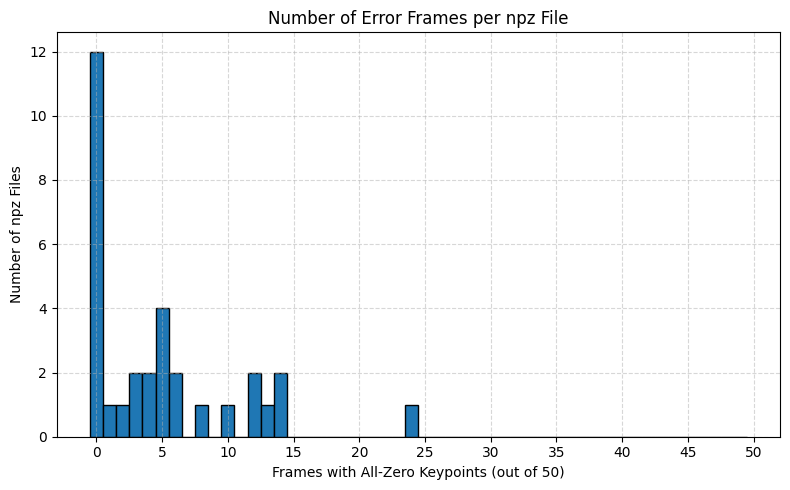

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

npz_dir = Path("pose_tensor_npz")

# 오류 프레임 개수 저장 리스트
error_counts = []

# 모든 npz 파일 순회
for npz_path in tqdm(npz_dir.rglob("*.npz")):
    try:
        data = np.load(npz_path)
        pose = data["pose"]  # shape: (50, 17, 2)

        # 프레임별로 all zero인지 확인
        frame_errors = np.all(pose == 0, axis=(1, 2))  # shape: (50,)
        error_count = np.sum(frame_errors)
        error_counts.append(error_count)

    except Exception as e:
        print(f"[❌ 오류 발생] {npz_path.name}: {e}")

# 히스토그램 출력
plt.figure(figsize=(8, 5))
plt.hist(error_counts, bins=range(0, 51, 1), edgecolor='black', align='left')
plt.title("Number of Error Frames per npz File")
plt.xlabel("Frames with All-Zero Keypoints (out of 50)")
plt.ylabel("Number of npz Files")
plt.xticks(range(0, 51, 5))
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

✅ GIF saved at 00151_H_A_BY_C3.gif (duration: 10.0s)


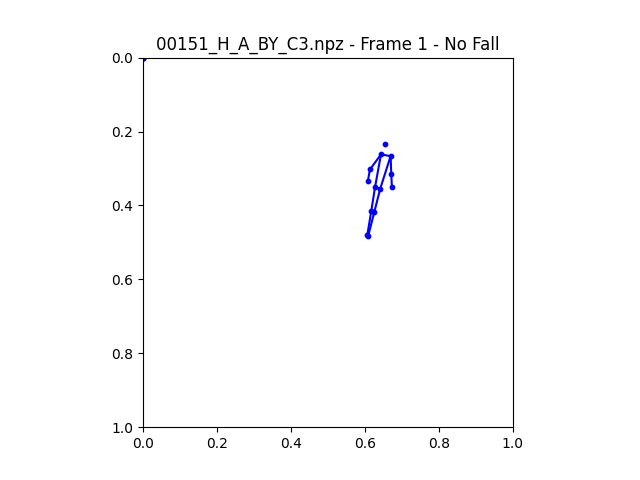

✅ GIF saved at 00003_H_A_FY_C5.gif (duration: 10.0s)


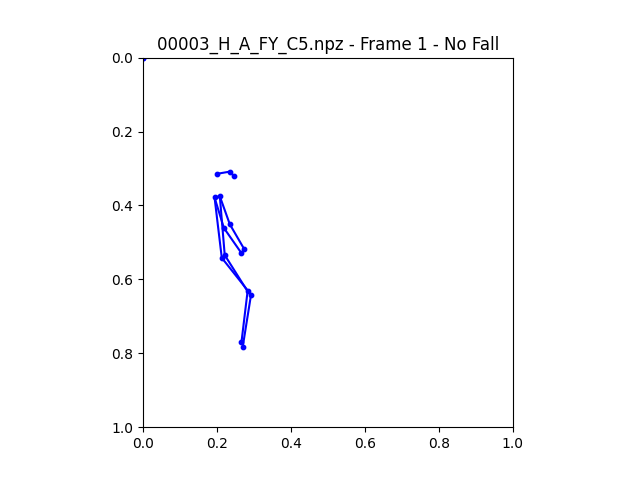

✅ GIF saved at 00047_H_A_N_C8.gif (duration: 10.0s)


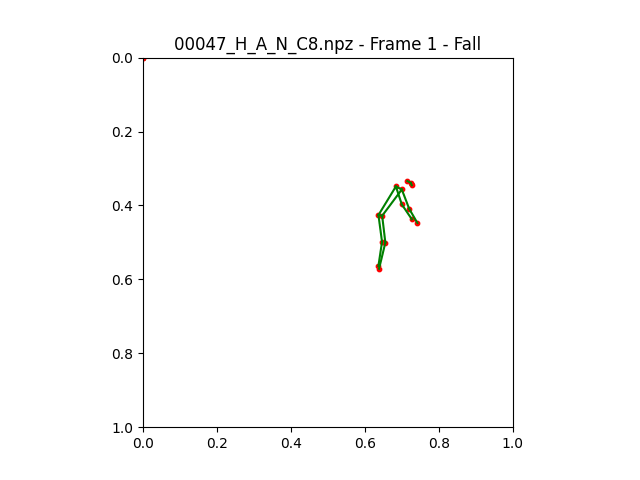

✅ GIF saved at 00151_H_A_BY_C2.gif (duration: 10.0s)


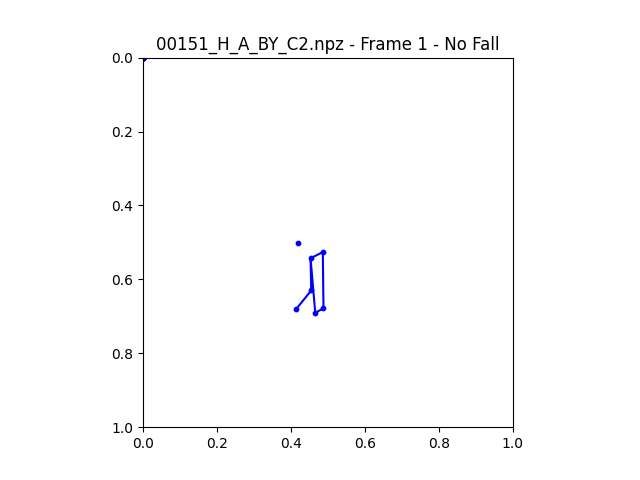

✅ GIF saved at 00151_H_A_BY_C1.gif (duration: 10.0s)


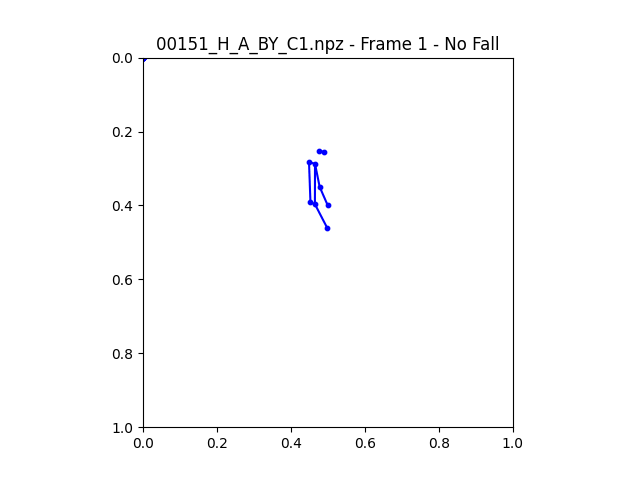

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pathlib import Path
import random
from IPython.display import Image, display

# configuration
NPZ_ROOT = Path("/content/pose_tensor_npz")
NUM_SAMPLES = 5                              # 출력할 npz 파일 수
TOTAL_DURATION_MS = 10_000                   # GIF 전체 재생 시간

# define COCO Skeleton
skeleton = [
    (0, 1), (0, 2), (1, 3), (2, 4),
    (5, 6), (5, 7), (7, 9), (6, 8), (8, 10),
    (5, 11), (6, 12), (11, 13), (13, 15),
    (12, 14), (14, 16), (11, 12)
]

# 디렉토리 내 npz 파일 전체에서 랜덤 선택
npz_files = list(NPZ_ROOT.rglob("*.npz"))
if len(npz_files) == 0:
    raise FileNotFoundError(f"No npz files found in {NPZ_ROOT}")
sampled_files = random.sample(npz_files, min(NUM_SAMPLES, len(npz_files)))

# 애니메이션 출력 함수
def visualize_npz_as_gif(npz_path):
    data = np.load(npz_path)
    pose_data = data['pose']
    label_data = data['label']
    frame_count = len(pose_data)
    interval_ms = TOTAL_DURATION_MS / frame_count

    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)
    ax.set_aspect('equal')

    def update(frame):
        ax.clear()
        ax.set_xlim(0, 1)
        ax.set_ylim(1, 0)
        ax.set_aspect('equal')
        ax.set_title(f"{npz_path.name} - Frame {frame+1} - {'Fall' if label_data[frame] == 1 else 'No Fall'}")
        pose_frame = pose_data[frame]
        ax.scatter(pose_frame[:, 0], pose_frame[:, 1], s=10, c='red' if label_data[frame] == 1 else 'blue')
        for i, j in skeleton:
            if all(pose_frame[i] > 0) and all(pose_frame[j] > 0):
                ax.plot([pose_frame[i, 0], pose_frame[j, 0]],
                        [pose_frame[i, 1], pose_frame[j, 1]],
                        'green' if label_data[frame] == 1 else 'blue')

    ani = animation.FuncAnimation(fig, update, frames=frame_count, repeat=True, interval=interval_ms)
    gif_path = npz_path.with_suffix(".gif")
    ani.save(gif_path, writer='pillow')
    plt.close(fig)

    print(f"✅ GIF saved at {gif_path.name} (duration: {TOTAL_DURATION_MS/1000:.1f}s)")
    display(Image(filename=str(gif_path)))

# 샘플 출력 반복
for npz_path in sampled_files:
    visualize_npz_as_gif(npz_path)
